In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 139.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from dataclasses import dataclass
import numpy as np
import random
import os
import wfdb
import random

@dataclass
class CFG:
    seed = 42
    records = [
        "100","101","102","103","104","105","106","107","108","109",
        "111","112","113","114","115","116","117","118","119","121",
        "122","123","124","200","201","202","203","205","207","208",
        "209","210","212","213","214","215","217","219","220","221",
        "222","223","228","230","231","232","233","234"
    ]
    window_sec = 2.0
    crop_len = 720
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    split_mode = "record"
    batch_size = 64
    epochs = 100
    z_dim = 100
    device = "cuda" if torch.cuda.is_available() else "cpu"





In [3]:
from sklearn.model_selection import train_test_split

def load_record(name, duration_sec=600):
    rec = wfdb.rdrecord(name, pn_dir="mitdb")
    ann = wfdb.rdann(name, "atr", pn_dir="mitdb")
    fs = rec.fs
    sig = rec.p_signal[:int(fs*duration_sec)]
    valid = ann.sample < int(fs*duration_sec)
    ann.sample = ann.sample[valid]
    ann.symbol = np.array(ann.symbol)[valid].tolist()
    return sig, ann, fs

def segment_beats(signal, ann, fs, window_sec):
    half = int(fs * window_sec / 2)
    beats = []

    for sample, sym in zip(ann.sample, ann.symbol):
        if sym != "N":
            continue

        start, end = sample - half, sample + half
        if start < 0 or end > len(signal):
            continue

        seg = signal[start:end, 0]

        # normalize
        seg = (seg - seg.mean()) / (seg.std() + 1e-8)
        seg = np.clip(seg, -5, 5) / 5.0

        beats.append(seg.astype(np.float32))

    if not beats:
        beat_len = int(fs * window_sec)
        return np.empty((0, beat_len), dtype=np.float32)

    return np.stack(beats)


def build_dataset(cfg):
    xs = []
    for r in cfg.records:
        sig, ann, fs = load_record(r)
        x = segment_beats(sig, ann, fs, cfg.window_sec)
        if x.size == 0:
            continue
        xs.append(x[:, None, :])  # (B, 1, T)

    X = np.concatenate(xs, axis=0)

    n = len(X)
    n_train = int(n * cfg.train_ratio)
    n_val = int(n * cfg.val_ratio)

    X_train = X[:n_train]
    X_val = X[n_train:n_train + n_val]
    X_test = X[n_train + n_val:]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, X_val, X_test



class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]


In [4]:
X_train, _, _ = build_dataset(CFG)


Train: 17557, Val: 3762, Test: 3763


In [5]:
train_ds = ECGDataset(X_train)

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)


In [6]:
class ECGGenerator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.fc = nn.Linear(z_dim, 256 * 45)

        self.net = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 4, 2, 1),
            nn.LayerNorm([128, 90]),
            nn.ReLU(),

            nn.ConvTranspose1d(128, 64, 4, 2, 1),
            nn.LayerNorm([64, 180]),
            nn.ReLU(),

            nn.ConvTranspose1d(64, 32, 4, 2, 1),
            nn.LayerNorm([32, 360]),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 45)
        return self.net(x)


In [7]:
class ECGDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(256 * 45, 1)

    def forward(self, x):
        h = self.conv(x)
        return self.fc(h.view(x.size(0), -1))


In [11]:

def gradient_penalty(D, real, fake, device):
    alpha = torch.rand(real.size(0), 1, 1, device=device)
    interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)

    d_interp = D(interp)

    grads = torch.autograd.grad(
        outputs=d_interp,
        inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(grads.size(0), -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()


def temporal_smoothness_loss(fake):
    d1 = fake[:, :, 1:] - fake[:, :, :-1]
    d2 = d1[:, :, 1:] - d1[:, :, :-1]
    return torch.mean(torch.abs(d2))


def spectral_loss(fake, real):
    fake_fft = torch.fft.rfft(fake, dim=-1).abs()
    real_fft = torch.fft.rfft(real, dim=-1).abs()
    return torch.mean((fake_fft - real_fft) ** 2)

In [12]:
def train_wgan(
    G, D, loader, device,
    epochs=100,
    z_dim=100,
    n_critic=5,
    gp_lambda=10,
    lambda_smooth=0.2,
    lambda_spec=0.05
):
    G.to(device)
    D.to(device)

    opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
    opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

    for epoch in range(epochs):
        for real in loader:
            real = real.to(device)
            bs = real.size(0)

            z = torch.randn(bs, z_dim, device=device)
            fake = G(z).detach()

            for _ in range(n_critic):
                d_real = D(real).mean()
                d_fake = D(fake).mean()
                gp = gradient_penalty(D, real, fake, device)

                d_loss = d_fake - d_real + gp_lambda * gp

                opt_D.zero_grad()
                d_loss.backward()
                opt_D.step()

            z = torch.randn(bs, z_dim, device=device)
            fake = G(z)

            g_loss = -D(fake).mean()
            g_loss += lambda_smooth * temporal_smoothness_loss(fake)
            g_loss += lambda_spec * spectral_loss(fake, real)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"D: {d_loss.item():.4f} | G: {g_loss.item():.4f}"
        )


In [13]:
torch.manual_seed(CFG.seed)

G = ECGGenerator(z_dim=CFG.z_dim)
D = ECGDiscriminator()

train_wgan(
    G=G,
    D=D,
    loader=train_loader,
    device=CFG.device,
    epochs=CFG.epochs,
    z_dim=CFG.z_dim,
    n_critic=5,
    gp_lambda=10
)


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100] | D: -2.3789 | G: 1.5579
Epoch [2/100] | D: -1.9520 | G: -2.6243
Epoch [3/100] | D: -1.5869 | G: -3.6939
Epoch [4/100] | D: -1.2881 | G: -3.3180
Epoch [5/100] | D: -1.2810 | G: -5.5978
Epoch [6/100] | D: -1.3162 | G: -7.7745
Epoch [7/100] | D: -1.1432 | G: -8.0395
Epoch [8/100] | D: -1.2069 | G: -5.9112
Epoch [9/100] | D: -1.1314 | G: -6.3816
Epoch [10/100] | D: -1.1490 | G: -9.3261
Epoch [11/100] | D: -1.2523 | G: -9.2535
Epoch [12/100] | D: -1.0499 | G: -10.1654
Epoch [13/100] | D: -1.0824 | G: -11.0788
Epoch [14/100] | D: -1.0654 | G: -11.8060
Epoch [15/100] | D: -1.0563 | G: -10.9525
Epoch [16/100] | D: -1.1302 | G: -10.2209
Epoch [17/100] | D: -0.9726 | G: -9.5984
Epoch [18/100] | D: -1.1567 | G: -8.5725
Epoch [19/100] | D: -1.0227 | G: -7.5829
Epoch [20/100] | D: -1.0489 | G: -8.4553
Epoch [21/100] | D: -1.0426 | G: -7.1418
Epoch [22/100] | D: -0.9808 | G: -5.5220
Epoch [23/100] | D: -0.9801 | G: -4.6349
Epoch [24/100] | D: -0.9700 | G: -5.0840
Epoch [25/100] | D: -

In [18]:
import matplotlib.pyplot as plt

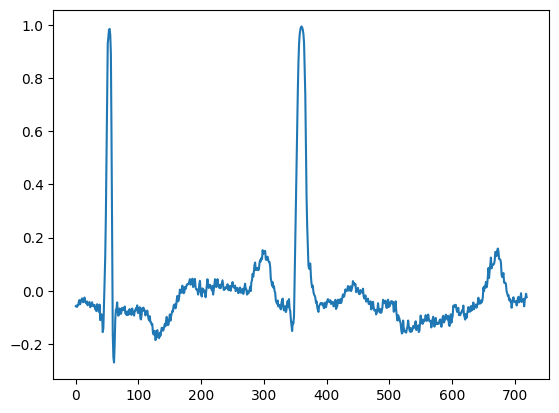

In [28]:
G.eval()
z = torch.randn(1, 100).to(CFG.device)

with torch.inference_mode():
    ecg_normal = G(z)

ecg_plot = ecg_normal.squeeze().detach().cpu().numpy()

plt.plot(ecg_plot)

In [29]:
torch.save(G.state_dict(), "ecg_wgan_generator.pt")
torch.save(D.state_dict(), "ecg_wgan_discriminator.pt")